In [1]:
'''
LOAD TEST WEB SERVER

CREATED: 13-APR-2022
LAST EDIT: 19-APR-2022
AUTHORS: DUANE RINEHART

'''
import os
import time
import pandas as pd


win_data_dir = 'E:/dev/web_server_load_test/'
linux_data_dir = '/mnt/e/dev/web_server_load_test/'


def load_app_constants():
    '''
    LOAD APP/ENVIRONMENT SETTINGS (ESP. CROSS-PLATFORM)
    '''
    if os.name == "nt":
        input_fullPath = os.path.join(win_data_dir)
    else:
        input_fullPath = os.path.join(linux_data_dir)
    return input_fullPath


def sizeof_fmt(num, suffix="B"):
    for unit in ["", "Ki", "Mi", "Gi", "Ti", "Pi", "Ei", "Zi"]:
        if abs(num) < 1024.0:
            return f"{num:3.1f}{unit}{suffix}"
        num /= 1024.0
    return f"{num:.1f}Yi{suffix}"


def capture_dir_listing(data_root):
    '''
    PRIOR LIST OF REPRESENTATIVE DIRECTORY CONTENTS GENERATED WITH:
    [ON pons.dk.ucsd.edu]
    cd /data/neuroglancer/DK55/neuroglancer_data/C1
    DIR='325_325_20000' && ls -l $DIR | awk 'BEGIN {OFS="\t"} { print $9, $5 }' > ~/"$DIR.tsv"

    '''

    input_filename = 'DK55_ls_v2.tsv'
    input_fullPath = os.path.join(data_root, input_filename)

    start = time.time()
    dfFileList = pd.read_csv(input_fullPath, sep='\t', names=['fname', 'size_(bytes)'], header=None)
    dfFileList.index.name = 'id'
    end = time.time()
    print(f"Read tsv: {input_filename}")
    print('Operation time: ', (end-start), "sec")
    return dfFileList

data_root = load_app_constants()
files_size_array = capture_dir_listing(data_root)


Read tsv: DK55_ls_v2.tsv
Operation time:  12.990773677825928 sec


In [2]:
print('n = ', len(files_size_array.index))
print('μ =', sizeof_fmt(files_size_array['size_(bytes)'].mean()))
print('median = ', sizeof_fmt(files_size_array['size_(bytes)'].median()))
print('σ = ', files_size_array['size_(bytes)'].std())

n =  16208461
μ = 39.8KiB
median =  163.0B
σ =  153075.00498381534


array([[<AxesSubplot:title={'center':'size_(bytes)'}>]], dtype=object)

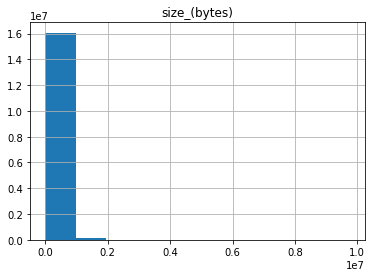

In [3]:
files_size_array.hist('size_(bytes)')

In [109]:
#REPRESENTATIVE IMAGES DURING SESSION SUM IS BASED ON HISTORICAL DAILY AVERAGE (https://activebrainatlas.ucsd.edu/awstats/awstats.pl)
#MAR, 2022 AVG 8.82GB
aggregate_threshold = (8.82e+9) # IN BYTES
#aggregate_threshold = (2000) # IN BYTES
aggregate_file_size = 0
files_size_array['selected'] = ' ' # ADD TO EXISTING DATAFRAME

for i in files_size_array.sample(frac=1).iterrows(): #ref: https://stackoverflow.com/questions/43509114/randomly-sample-rows-of-a-dataframe-until-the-desired-sum-of-a-column-is-reached
    if (aggregate_file_size + i[1]['size_(bytes)']) <= aggregate_threshold:
        aggregate_file_size += i[1]['size_(bytes)']
        files_size_array.at[i[0], 'selected'] = 1

# SAVE RESULTS TO FILE ('size_(bytes)' COLUMN SUM SHOULD EQUAL aggregate_threshold)
data_root = load_app_constants()
out_filename = 'load_test_target_transfer_list.xlsx'
output_fullPath = os.path.join(data_root, out_filename)
files_size_array.index.name = 'id'
files_size_array[files_size_array['selected']==1].to_excel(output_fullPath, columns=['fname','size_(bytes)'])